In [1]:
%pip install gymnasium
%pip install optuna
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import Env
from gymnasium.spaces import Discrete
import time
import optuna



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


/Users/nikhilsaji/tensorflow-Python_v3.10/TF_P3_10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class TreasureHuntEnv(Env):
    def __init__(self):
        self.action_space = Discrete(4)  
        self.observation_space = Discrete(25)
        self.max_timesteps = 100
        self.cumulative_reward = 0
        self.grid_size = (5,5)
        self.agent_pos = [0, 0]
        self.goal_pos = [4, 4]
        self.timestep = 0
        self.state = np.zeros(self.grid_size)
        self.treasures = [(0,3),(2, 3)] 
        self.traps = [(1, 0), (1, 3),(3,3)] 
        self.loadRewards()
        
        

    def reset(self):
        self.loadRewards()
        self.agent_pos = [0, 0]  
        self.timestep = 0
        self.cumulative_reward = 0
        self.state[tuple(self.agent_pos)] = 15
        observation = self.state.flatten()
        return self.agent_pos, observation

    def step(self, action):    
        if action == 0:  # Up
            self.agent_pos[0] -= 1
        elif action == 1:  # Right
            self.agent_pos[1] += 1
        elif action == 2:  # Down
            self.agent_pos[0] += 1
        elif action == 3:  # Left
            self.agent_pos[1] -= 1

        self.agent_pos = np.clip(self.agent_pos, 0, self.grid_size[0] - 1)
        self.timestep += 1

        reward=self.addRewards()
        self.cumulative_reward += reward

        terminated = tuple(self.agent_pos) == tuple(self.goal_pos)
        truncated = self.timestep >= self.max_timesteps

        self.loadRewards()
        self.state[tuple(self.agent_pos)] = 15
        observation = self.state.flatten()

        info = {}
        return self.agent_pos, reward, terminated, truncated,observation,info

    def render(self): 
        plt.imshow(self.state)
        plt.show()
    
    def loadRewards(self):
        self.state = np.zeros(self.grid_size)
        for t in self.treasures:
            self.state[t] = 5
        for tr in self.traps:
            self.state[tr] = -5 
        self.state[tuple(self.goal_pos)] = 10

    def addRewards(self):
        if tuple(self.agent_pos) == tuple(self.goal_pos):
            reward = 100 
        elif tuple(self.agent_pos) in self.treasures:
            reward = 20 
            self.treasures.remove(tuple(self.agent_pos)) # remove the treasure once collected
        elif tuple(self.agent_pos) in self.traps:
            reward = -20
        else:
            reward = -0.5
        return reward


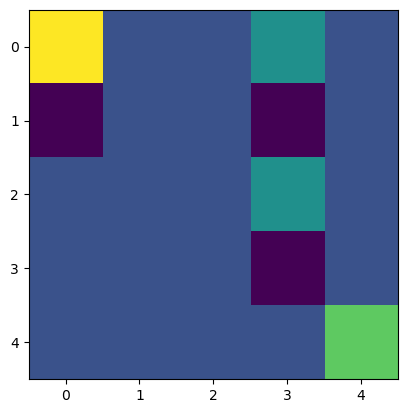

TimeStep: 1, State: [0 1], Action: 1, Reward: -0.5, Cumulative Reward: -0.5


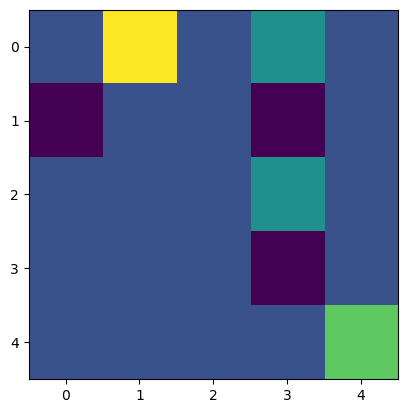

TimeStep: 2, State: [0 1], Action: 0, Reward: -0.5, Cumulative Reward: -1.0


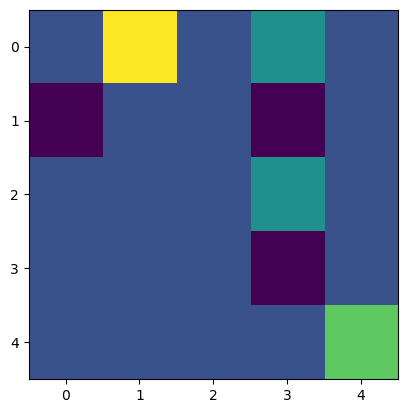

TimeStep: 3, State: [0 0], Action: 3, Reward: -0.5, Cumulative Reward: -1.5


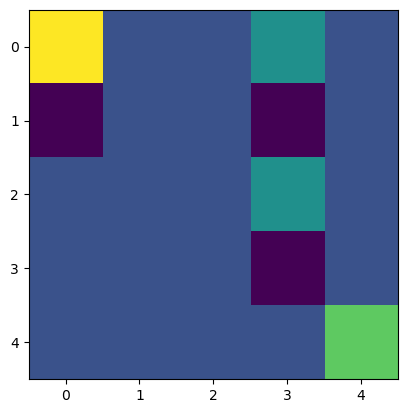

TimeStep: 4, State: [0 0], Action: 3, Reward: -0.5, Cumulative Reward: -2.0


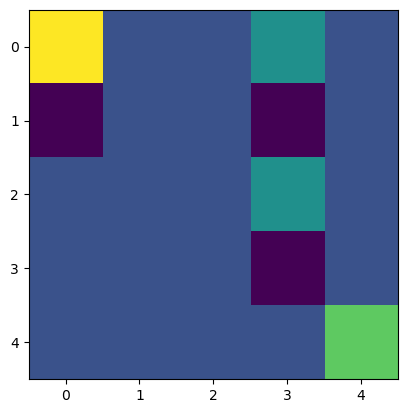

TimeStep: 5, State: [0 0], Action: 0, Reward: -0.5, Cumulative Reward: -2.5


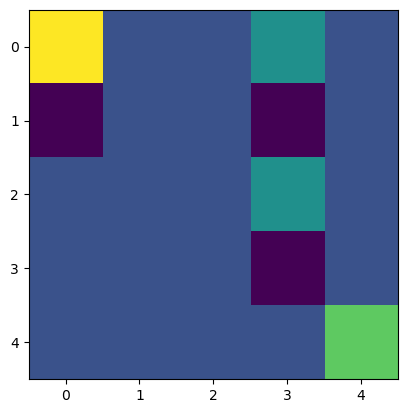

TimeStep: 6, State: [1 0], Action: 2, Reward: -20, Cumulative Reward: -22.5


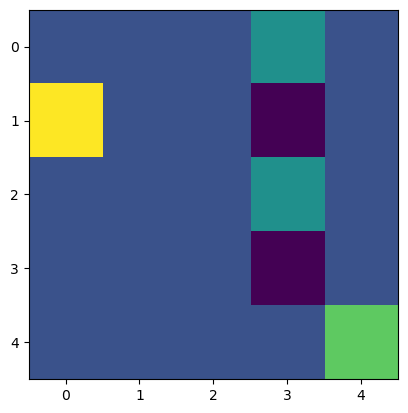

TimeStep: 7, State: [0 0], Action: 0, Reward: -0.5, Cumulative Reward: -23.0


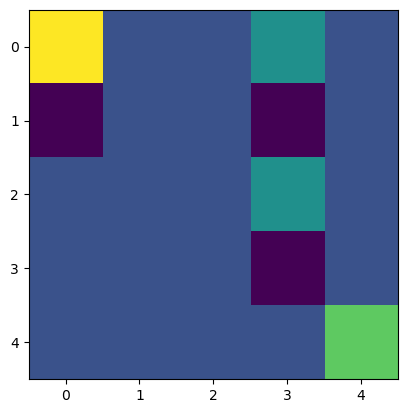

TimeStep: 8, State: [1 0], Action: 2, Reward: -20, Cumulative Reward: -43.0


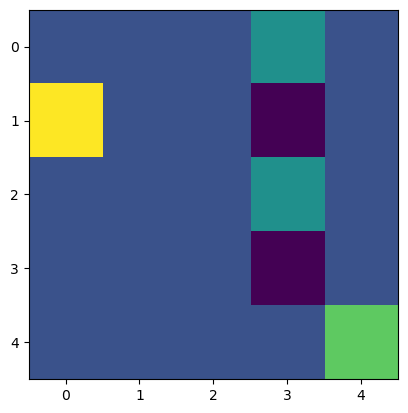

TimeStep: 9, State: [2 0], Action: 2, Reward: -0.5, Cumulative Reward: -43.5


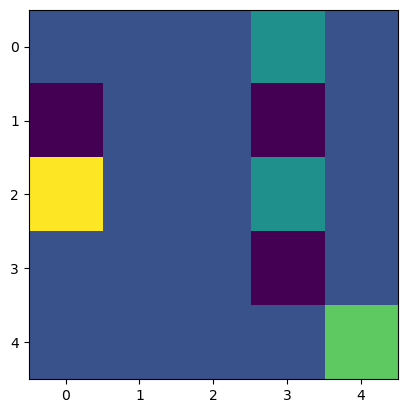

TimeStep: 10, State: [2 1], Action: 1, Reward: -0.5, Cumulative Reward: -44.0


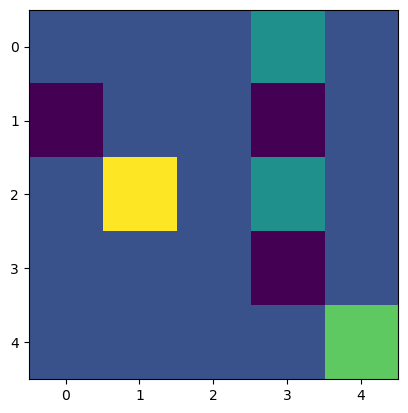

TimeStep: 11, State: [2 2], Action: 1, Reward: -0.5, Cumulative Reward: -44.5


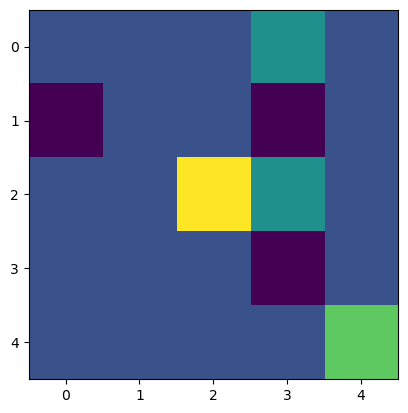

TimeStep: 12, State: [3 2], Action: 2, Reward: -0.5, Cumulative Reward: -45.0


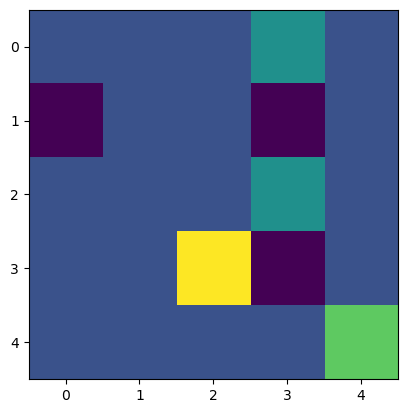

TimeStep: 13, State: [3 3], Action: 1, Reward: -20, Cumulative Reward: -65.0


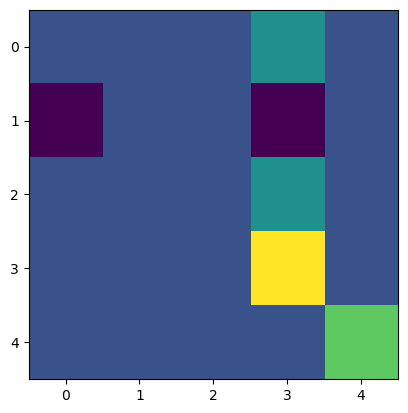

TimeStep: 14, State: [3 2], Action: 3, Reward: -0.5, Cumulative Reward: -65.5


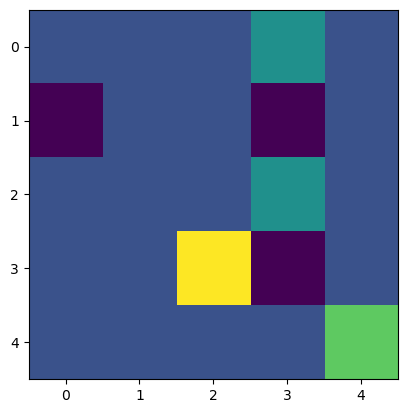

TimeStep: 15, State: [2 2], Action: 0, Reward: -0.5, Cumulative Reward: -66.0


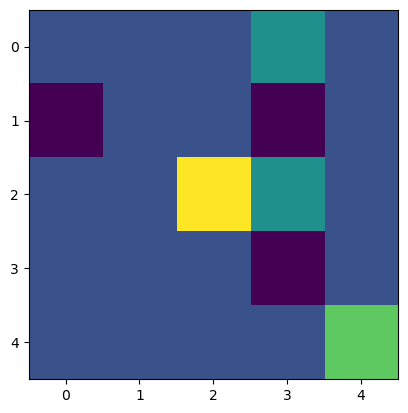

TimeStep: 16, State: [3 2], Action: 2, Reward: -0.5, Cumulative Reward: -66.5


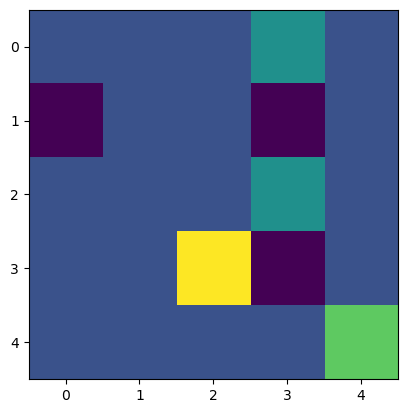

TimeStep: 17, State: [4 2], Action: 2, Reward: -0.5, Cumulative Reward: -67.0


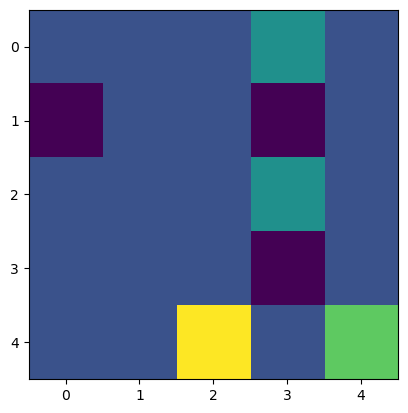

TimeStep: 18, State: [4 3], Action: 1, Reward: -0.5, Cumulative Reward: -67.5


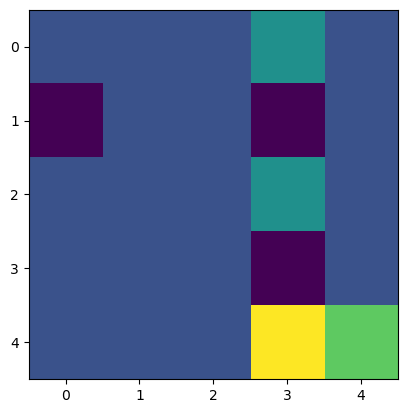

TimeStep: 19, State: [4 4], Action: 1, Reward: 100, Cumulative Reward: 32.5


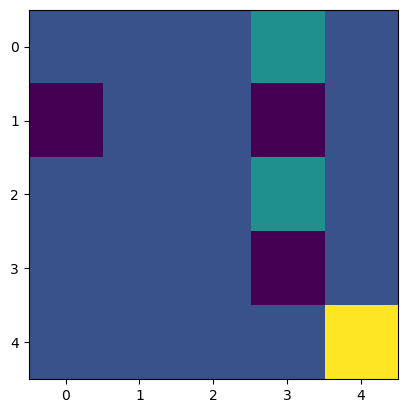

Final Cumulative Reward: 32.5


In [27]:
env = TreasureHuntEnv()
state = env.reset()
env.render()

terminated, truncated, i = False, False, 0
while not terminated and not truncated:
    action = env.action_space.sample()
    state, reward, terminated, truncated, observation, info = env.step(action)
    print(f"TimeStep: {i+1}, State: {state}, Action: {action}, Reward: {reward}, Cumulative Reward: {env.cumulative_reward}")
    env.render()
    i += 1

print(f"Final Cumulative Reward: {env.cumulative_reward}")

In [28]:
def SARSA(env, episodes, alpha, gamma, epsilon, epsilon_decay, minimum_epsilon, maximum_timestep):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_per_episode = []
    epsilon_value = []

    for episode in range(episodes):
        state, _ = env.reset()
        current_state = np.ravel_multi_index(state, env.grid_size)  
        current_action = np.random.choice(env.action_space.n) if np.random.rand() < epsilon else np.argmax(Q[current_state])
        reward_sum = 0

        for t in range(maximum_timestep):
            next_state, reward, goal_reached, cutoff, _, _ = env.step(current_action)
            reward_sum += reward
            next_state_index = np.ravel_multi_index(next_state, env.grid_size)
            next_action = (np.random.choice(env.action_space.n)
                if np.random.rand() < epsilon
                else np.argmax(Q[next_state_index])
            )

            Q[current_state, current_action] += alpha * (reward + gamma * Q[next_state_index, next_action] - Q[current_state, current_action])
            current_state, current_action = next_state_index, next_action

            if goal_reached or cutoff:
                break

        epsilon = max(epsilon * epsilon_decay, minimum_epsilon)

        rewards_per_episode.append(reward_sum)
        epsilon_value.append(epsilon)

    return Q, rewards_per_episode, epsilon_value



In [29]:
episodes = 500
alpha = 0.1  
gamma = 0.9  
epsilon = 1.0  
epsilon_decay = 0.99
minimum_epsilon = 0.1
maximum_timestep = 100

initial_Q = np.zeros((env.observation_space.n, env.action_space.n))  
trained_Q, rewards, epsilon_value = SARSA(env, episodes, alpha, gamma, epsilon, epsilon_decay, minimum_epsilon, maximum_timestep)
print("Initial Q-table:")
print(initial_Q)
print("\nTrained Q-table:")
print(trained_Q)


Initial Q-table:
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q-table:
[[  3.25949115  31.41473923 -28.857636     6.58893943]
 [ 13.40930594  37.54141552   1.2400714   11.84011085]
 [ 19.46721543  -1.28007785  44.35709767  10.5697945 ]
 [ -4.49483023  11.16705818 -18.74139462  -3.93983251]
 [ -2.10730667  -2.89329767  23.40471671  -5.28040596]
 [ -8.52484725 -10.17591224  -1.45321362 -26.32565421]
 [ -4.43376301  31.14942528  -0.59456064 -29.98150369]
 [ 23.37328244 -11.66604183  50.03489578   2.53484546]
 [ -3.02232287  -3.68412445  27.51114533  -3.53088067]
 [ -2.53960912   2.88435656  49.76197107 -19.8182942 ]
 [-27.86036151  -1.9280202    5.9022608

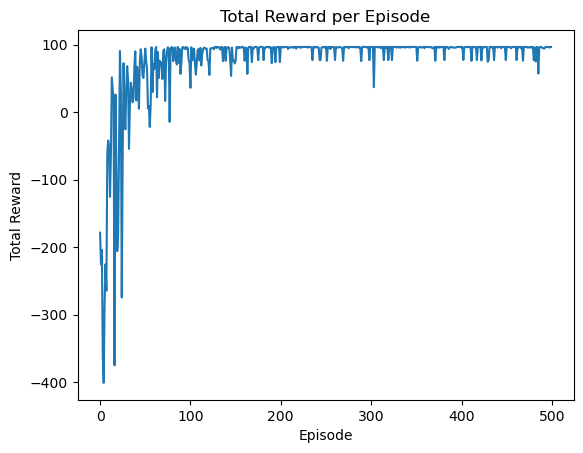

In [30]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode")
plt.show()


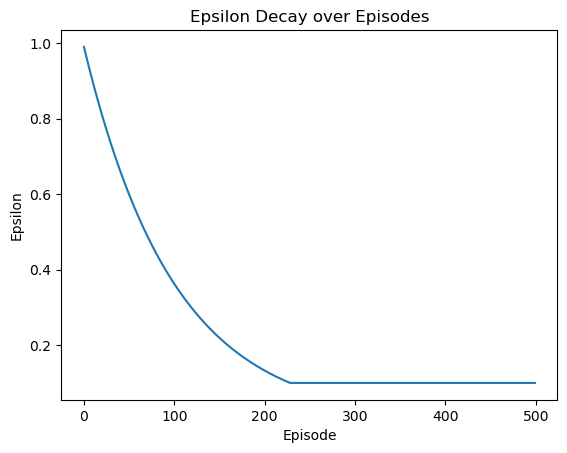

In [31]:
plt.plot(epsilon_value)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay over Episodes")
plt.show()


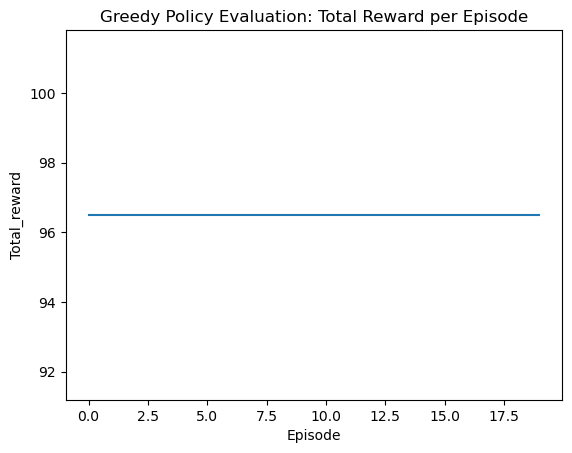

In [32]:
def evaluate_policy(env, Q, episodes=20):
    rewards = []
    for _ in range(episodes):
        state, _ = env.reset()
        current_state = np.ravel_multi_index(state, env.grid_size)
        reward_sum = 0
        done = False

        while not done:
            current_action = np.argmax(Q[current_state])
            next_state, reward, goal_reached, cutoff, _, _ = env.step(current_action)
            reward_sum += reward
            current_state = np.ravel_multi_index(next_state, env.grid_size)

            if goal_reached or cutoff:
                break

        rewards.append(reward_sum)

    return rewards

greedy_rewards = evaluate_policy(env, trained_Q)
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total_reward")
plt.title("Greedy Policy Evaluation: Total Reward per Episode")
plt.show()


In [33]:
def objective(trial):
    gamma = trial.suggest_categorical("gamma", [0.7, 0.89, 0.99])
    epsilon_decay = trial.suggest_categorical("epsilon_decay", [0.93, 0.975, 0.999])
    _, rewards, _ = SARSA(env, episodes, alpha, gamma, epsilon, epsilon_decay, minimum_epsilon, maximum_timestep)
    return np.mean(rewards[-200:])  

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_params)



[I 2024-11-21 21:16:26,496] A new study created in memory with name: no-name-6f85080e-b77f-4f82-9ab9-0fda21074ec2
[I 2024-11-21 21:16:26,554] Trial 0 finished with value: 94.35 and parameters: {'gamma': 0.99, 'epsilon_decay': 0.975}. Best is trial 0 with value: 94.35.
[I 2024-11-21 21:16:26,803] Trial 1 finished with value: 56.3475 and parameters: {'gamma': 0.7, 'epsilon_decay': 0.999}. Best is trial 0 with value: 94.35.
[I 2024-11-21 21:16:26,856] Trial 2 finished with value: 94.9375 and parameters: {'gamma': 0.99, 'epsilon_decay': 0.975}. Best is trial 2 with value: 94.9375.
[I 2024-11-21 21:16:26,905] Trial 3 finished with value: 93.0375 and parameters: {'gamma': 0.99, 'epsilon_decay': 0.93}. Best is trial 2 with value: 94.9375.
[I 2024-11-21 21:16:26,958] Trial 4 finished with value: 93.3725 and parameters: {'gamma': 0.99, 'epsilon_decay': 0.93}. Best is trial 2 with value: 94.9375.
[I 2024-11-21 21:16:27,017] Trial 5 finished with value: 93.665 and parameters: {'gamma': 0.7, 'epsi

Best hyperparameters: {'gamma': 0.99, 'epsilon_decay': 0.975}


In [34]:
best_params = study.best_params
final_Q_table, final_rewards, final_epsilon_values = SARSA(
    env, episodes, alpha, best_params["gamma"], epsilon, best_params["epsilon_decay"], minimum_epsilon, maximum_timestep
)


In [35]:
def re_evaluate_greedy_policy(env, Q, episodes=10, max_timesteps=maximum_timestep):
    rewards = []
    for episode in range(episodes):
        state, _ = env.reset()
        current_state = np.ravel_multi_index(state, env.grid_size)
        total_reward = 0

        for t in range(max_timesteps):
            current_action = np.argmax(Q[current_state])
            next_state, reward, goal_reached, cutoff, _, _ = env.step(current_action)
            total_reward += reward
            current_state = np.ravel_multi_index(next_state, env.grid_size)
            if goal_reached or cutoff:
                break

        rewards.append(total_reward)
    return rewards

re_evaluated_rewards = re_evaluate_greedy_policy(env, final_Q_table, episodes=10)
print(f"Average Reward (Greedy Policy): {np.mean(re_evaluated_rewards)}")

Average Reward (Greedy Policy): 96.5


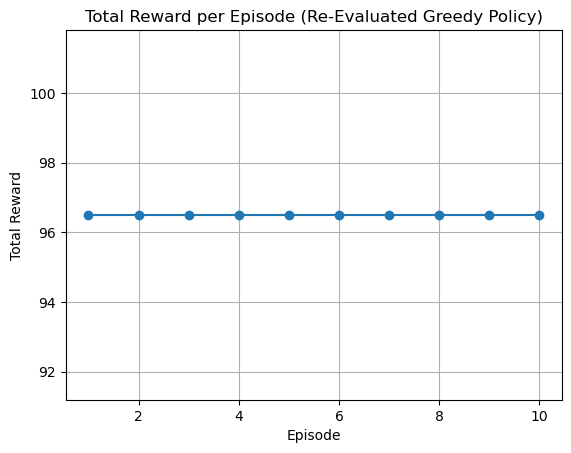

In [36]:
plt.plot(range(1, len(re_evaluated_rewards) + 1), re_evaluated_rewards, marker='o')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward per Episode (Re-Evaluated Greedy Policy)")
plt.grid()
plt.show()

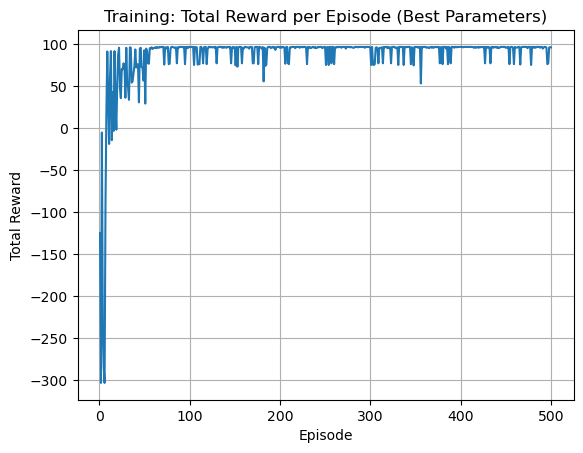

In [37]:
plt.plot(range(1, len(final_rewards) + 1), final_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training: Total Reward per Episode (Best Parameters)")
plt.grid()
plt.show()

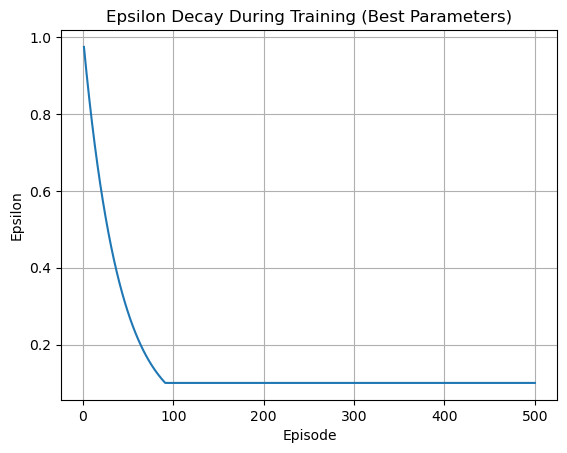

In [38]:
plt.plot(range(1, len(final_epsilon_values) + 1), final_epsilon_values)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay During Training (Best Parameters)")
plt.grid()
plt.show()